## Exo MNISTclassif

The goal of this exercise is to implement and compare three different neural networks. We will use the PyTorch lightning library to implement the networks.

### Guidelines:

This is a notebook to be *completed* and *commented*. The parts to be edited are indicated by a TO DO; the expected number of lines of code is given as an indication. The networks are already implemented, you just have to play with them. No knowledge of PyTorch lightning is required, check the already implemented code to understand the specific functions.

In [1]:
import numpy as np # to handle matrix and data operation
import matplotlib.pyplot as plt   #image visualisation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import lightning as L

# 1) Load and treat the data

## 1.1) Load

The first value is the "label", that is, the actual digit that the handwriting is supposed to represent, such as a "7" or a "9". It is the answer to which the neural network is aspiring to classify.
The subsequent values, all comma separated, are the pixel values of the handwritten digit. The size of the pixel array is 28 by 28, so there are 784 values after the label.

In [2]:
train=np.genfromtxt('mnist_train_1000.csv',delimiter=',')
test=np.genfromtxt('mnist_test_100.csv',delimiter=',')

#1.2) treat the initial data in numpy
X_train=train[1:,1:]/255
y_train=train[1:,0].reshape((X_train.shape[0],1)).astype(int)

X_test=test[1:,1:]/255
y_test=test[1:,0].reshape((X_test.shape[0],1)).astype(int)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(998, 784)
(998, 1)
(98, 784)
(98, 1)


## 1.2) Define a function to visualize an observation and use it

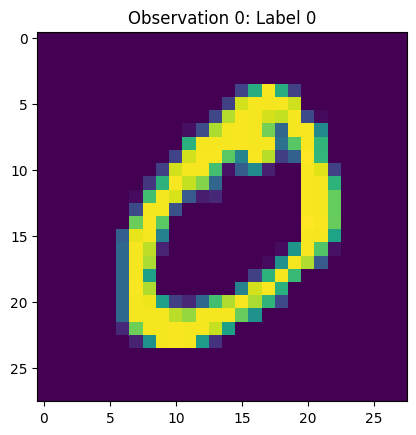

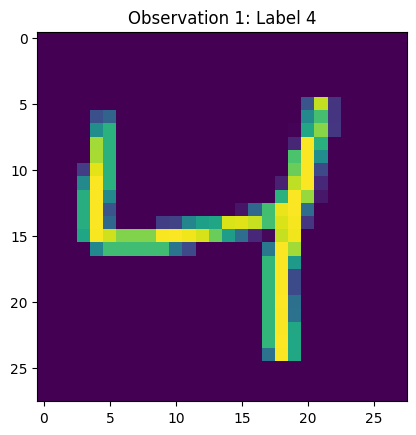

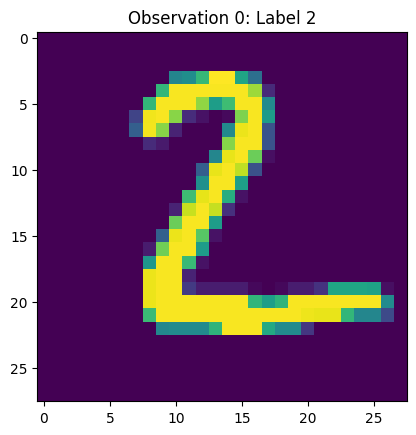

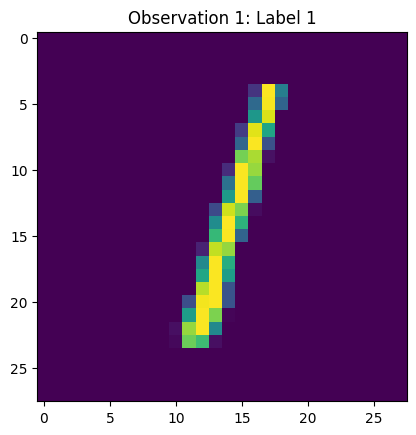

In [3]:
def ShowMNISTObservation(X_data,y_data,obsNb=0):
    plt.clf()
    plt.imshow(X_data[obsNb,:].reshape((28,28)))
    plt.title('Observation '+str(obsNb)+': Label '+str((y_data[obsNb,0])))
    plt.show()

ShowMNISTObservation(X_train,y_train,0)
ShowMNISTObservation(X_train,y_train,1)
ShowMNISTObservation(X_test,y_test,0)
ShowMNISTObservation(X_test,y_test,1)

## 1.3) Convert the numpy array as torch tensor (equivalent structures but used by pytorch)

In [4]:
torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor).float()
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor).float() # data type is long (i.e. 64bit)

torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor).float()
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor).float() # data type is long

**QUESTION 1:** Understand well what are the data of this machine learning problem. 
            May you solve this problem using SVM, linear regression, random forests 
            or K-means?

#TO DO: Les données pourraient être traitées avec une regression linéaire ou les SVM. Ces modèles ne permettent cependant pas de tenir compte de la proximité entre les differents pixels !!! Il seront alors très vraisemblablement sous-efficaces. 

# 2) Define three classes of neural networks

In [5]:
class MLP(L.LightningModule):
    """
    Multi-layer perceptron adapted to the inputs images having 784 pixels
    and the output labels having 10 possible values (0,1,...,9)
    """
    def __init__(self):
        super().__init__()
        self.training_step_outputs = []
        
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)

    def forward(self, x):
        x = x.view(-1,784)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.log_softmax(x, dim=1)

    def backward(self, loss):
        self.training_step_outputs.append(loss.detach().cpu().numpy())
        loss.backward()

    def training_step(self, batch):
        x, y = batch
        x = x.view(-1,784)
        z = self.forward(x)
        loss = F.mse_loss(z, y)
        return loss

    def configure_optimizers(self):
        otimizer = torch.optim.Adam(self.parameters(),lr=1e-3)
        return otimizer

mlp = MLP()
print(mlp)

class CNN(L.LightningModule):
    """
    Basic convolutional neural network
    """

    #Our batch shape for input x is (1, 28, 28)

    def __init__(self):
        super().__init__()
        self.training_step_outputs = []

        #Input channels = 1, output channels = 6
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #1536 input features, 64 output features (see sizing flow below)
        self.fc1 = nn.Linear(6 * 14 * 14, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        #Computes the activation of the first convolution
        #Size changes from (1, 28, 28) to (6, 28, 28)
        x = F.relu(self.conv1(x))
        
        #Size changes from (6, 28, 28) to (6, 14, 14)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (6, 14, 14) to (1, 1176)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 6 * 14 *14)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 1176) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        
        return x

    def backward(self, loss):
        self.training_step_outputs.append(loss.detach().cpu().numpy())
        loss.backward()

    def training_step(self, batch):
        x, y = batch
        x = x.view(-1,1,28,28)
        z = self.forward(x)
        loss = F.mse_loss(z, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

cnn = CNN()
print(cnn)

class CNN2(L.LightningModule):
    """
    Deeper convolutional neural network than CNN
    """

    #Our batch shape for input x is (1, 28, 28)

    def __init__(self):
        super().__init__()
        self.training_step_outputs = []
        #Input channels = 1, output channels = 6
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(6, 6, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(6, 6, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #1536 input features, 64 output features (see sizing flow below)
        self.fc1 = nn.Linear(6 * 7 * 7, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        #Computes the activation of the first convolution
        x = x.view(-1,1,28,28)
        
        #Size changes from (1, 28, 28) to (6, 28, 28)
        x = F.relu(self.conv1(x))
        
        #Size changes from (6, 28, 28) to (6, 14, 14)
        x = self.pool(x)
        
        #convolution on the 6x14x14 image
        x = F.relu(self.conv2(x))
        
        #Size changes from (6, 14, 14) to (6, 7, 7)
        x = self.pool(x)

        #convolution on the 6x7x7 image
        x = F.relu(self.conv3(x))
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (6, 7, 7) to (1, 294)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 6 * 7 *7)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 294) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        
        return x

    def backward(self, loss):
        self.training_step_outputs.append(loss.detach().cpu().numpy())
        loss.backward()

    def training_step(self, batch):
        x, y = batch
        z = self.forward(x)
        loss = F.mse_loss(z, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

cnn2 = CNN2()
print(cnn2)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)
CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1176, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
CNN2(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=294, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


# 3) Train the networks

In [6]:
mlp = MLP()
trainer = L.Trainer(min_epochs=1, max_epochs=2)
trainer.fit(mlp, (torch_X_train,torch_y_train))

cnn = CNN()
trainer = L.Trainer(min_epochs=1, max_epochs=2)
trainer.fit(cnn, (torch_X_train,torch_y_train))

cnn2 = CNN2()
trainer = L.Trainer(min_epochs=1, max_epochs=2)
trainer.fit(cnn2, (torch_X_train,torch_y_train))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | linear1 | Linear | 196 K  | train
1 | linear2 | Linear | 25.1 K | train
2 | linear3 | Linear | 1.0 K  | train
-------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.889     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Blondel\AppData\Local\Temp\ipykernel_4400\557712724.py:29: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(z, y)
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 60     | train
1 | pool  | MaxPool2d | 0      | train
2 | fc1   | Linear    | 75.3 K | train
3 | fc2   | Linear    | 650    | train
--------------------------------------------
76.0 K    Trainable params
0         Non-trainable params
76.0 K    Total params
0.304     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Blondel\AppData\Local\Temp\ipykernel_4400\557712724.py:92: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(z, y)
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 60     | train
1 | conv2 | Conv2d    | 330    | train
2 | conv3 | Conv2d    | 330    | train
3 | pool  | MaxPool2d | 0      | train
4 | fc1   | Linear    | 18.9 K | train
5 | fc2   | Linear    | 650    | train
--------------------------------------------
20.2 K    Trainable params
0         Non-trainable params
20.2 K    Total params
0.081     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Blondel\AppData\Local\Temp\ipykernel_4400\557712724.py:166: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(z, y)
`Trainer.fit` stopped: `max_epochs=2` reached.


# 4) Check the results

Text(0.5, 1.0, 'Loss')

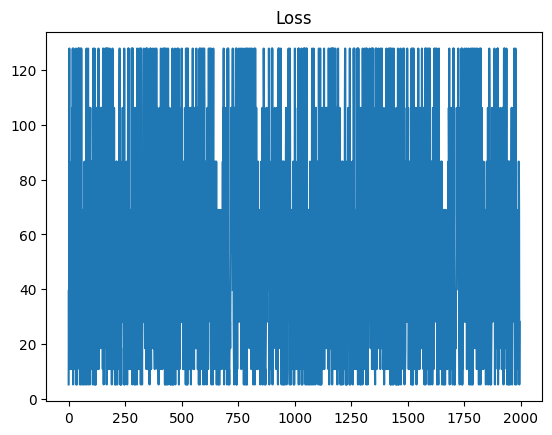

In [7]:
plt.plot(mlp.training_step_outputs)
plt.title('Loss')

Text(0.5, 1.0, 'Loss')

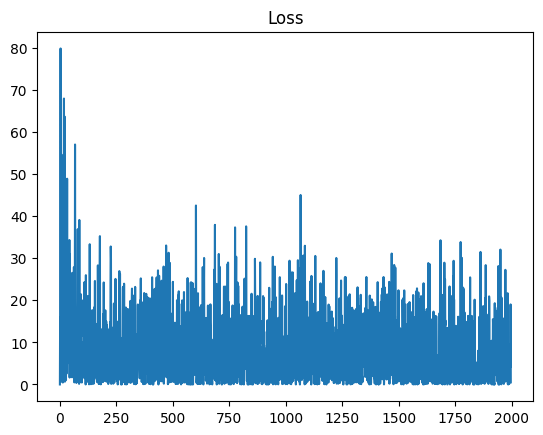

In [8]:
plt.plot(cnn.training_step_outputs)
plt.title('Loss')

Text(0.5, 1.0, 'Loss')

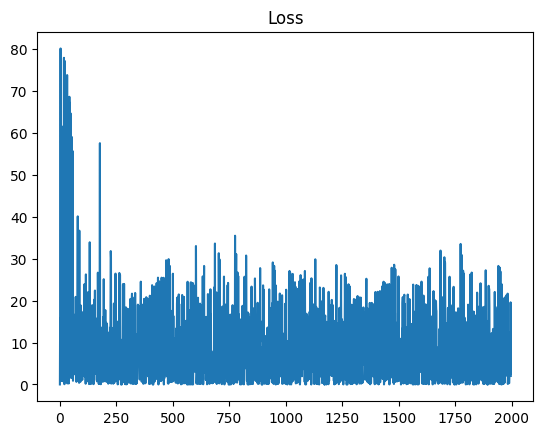

In [9]:
plt.plot(cnn2.training_step_outputs)
plt.title('Loss')

**QUESTION 2:** Fully understand and play the code. What is the main difference between
            the structure of the three networks? Does it seem to have an impact on
            the results?


#TO DO: Le premier modèle (MLP) ne contient que des couches denses et ne tient alors pas compte de la proximité entre les pixels. Il est alors extremement flexible, mais risque de sur-apprendre. Le deuxième modèle (CNN) a une couche de convolution et tient compte de la proximité entre les pixels. Le troisième modèle enchaine trois couches de convolutions à des echelles différentes (grace aux couches de pooling). Ce dernier modèle peut capturer des relations spatiales entre les pixels, a trois niveaux d'échelle.

L'apprentissage de ces trois réseaux de neurones semble avoir une efficacité similaire, si on ne la mesure que sur les données d'apprentissage.

**QUESTION 3:** Measure the percentages of good predictions on the test set. Which network
            has the best generalization properties here?

In [10]:
X_batch = torch_X_test[:,:].view(-1,1,28,28).float()
y_batch = torch_y_test[:,0]

print(X_batch.shape)
print(torch_X_test.shape)

with torch.no_grad():
  y_pred_mlp = mlp(X_batch)
  y_pred_cnn = cnn(X_batch)
  y_pred_cnn2 = cnn2(X_batch)

y_pred_mlp__label=y_pred_mlp.argmax(dim=1)
y_pred_cnn__label=y_pred_cnn.argmax(dim=1)
y_pred_cnn2__label=y_pred_cnn2.argmax(dim=1)

print('True labels:',y_batch)
print('Predicted labels (mlp):',y_pred_mlp__label)
print('Predicted labels (cnn):',y_pred_cnn__label)
print('Predicted labels (cnn2):',y_pred_cnn2__label)

print("Success rate (mlp):",torch.mean(1.*(y_pred_mlp__label==y_batch)))
print("Success rate (cnn):",torch.mean(1.*(y_pred_cnn__label==y_batch)))
print("Success rate (cnn2):",torch.mean(1.*(y_pred_cnn2__label==y_batch)))

torch.Size([98, 1, 28, 28])
torch.Size([98, 784])
True labels: tensor([2., 1., 0., 4., 1., 4., 9., 5., 9., 0., 6., 9., 0., 1., 5., 9., 7., 3.,
        4., 9., 6., 6., 5., 4., 0., 7., 4., 0., 1., 3., 1., 3., 4., 7., 2., 7.,
        1., 2., 1., 1., 7., 4., 2., 3., 5., 1., 2., 4., 4., 6., 3., 5., 5., 6.,
        0., 4., 1., 9., 5., 7., 8., 9., 3., 7., 4., 6., 4., 3., 0., 7., 0., 2.,
        9., 1., 7., 3., 2., 9., 7., 7., 6., 2., 7., 8., 4., 7., 3., 6., 1., 3.,
        6., 9., 3., 1., 4., 1., 7., 6.])
Predicted labels (mlp): tensor([9, 8, 8, 2, 2, 6, 7, 8, 3, 9, 7, 0, 2, 2, 1, 8, 6, 2, 9, 0, 9, 7, 2, 2,
        8, 7, 9, 9, 8, 0, 8, 2, 5, 2, 2, 8, 7, 7, 8, 8, 0, 9, 0, 7, 8, 8, 8, 2,
        9, 8, 2, 9, 7, 1, 9, 2, 2, 9, 2, 7, 5, 3, 9, 3, 8, 6, 8, 2, 0, 2, 2, 2,
        6, 9, 2, 7, 7, 9, 3, 8, 8, 5, 2, 2, 2, 7, 9, 2, 7, 2, 0, 8, 8, 2, 2, 9,
        9, 3])
Predicted labels (cnn): tensor([2, 2, 2, 2, 2, 1, 2, 7, 2, 2, 2, 0, 2, 2, 2, 0, 7, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 5

**Réponse** : cnn2 généralise mieux que cnn et mlp

**QUESTION 4:** Run the code on the 'mnist_train_100.csv' dataset, which has only
           100 observations instead of 1000! Do you manage to have good results
            on the test set?

In [11]:
#load data
train=np.genfromtxt('./mnist_train_100.csv',delimiter=',')

#treat data
X_train=train[1:,1:]/255
y_train=train[1:,0].reshape((X_train.shape[0],1))

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor).float()
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor).float() # data type is long (i.e. 64bit)

print(torch_X_train.shape)
print(torch_y_train.shape)

torch.Size([99, 784])
torch.Size([99, 1])


In [12]:
#train new models
mlp = MLP()
trainer = L.Trainer(min_epochs=1, max_epochs=2)
trainer.fit(mlp, (torch_X_train,torch_y_train))

cnn = CNN()
trainer = L.Trainer(min_epochs=1, max_epochs=2)
trainer.fit(cnn, (torch_X_train,torch_y_train))

cnn2 = CNN2()
trainer = L.Trainer(min_epochs=1, max_epochs=2)
trainer.fit(cnn2, (torch_X_train,torch_y_train))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | linear1 | Linear | 196 K  | train
1 | linear2 | Linear | 25.1 K | train
2 | linear3 | Linear | 1.0 K  | train
-------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.889     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Blondel\AppData\Local\Temp\ipykernel_4400\557712724.py:29: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(z, y)
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 60     | train
1 | pool  | MaxPool2d | 0      | train
2 | fc1   | Linear    | 75.3 K | train
3 | fc2   | Linear    | 650    | train
--------------------------------------------
76.0 K    Trainable params
0         Non-trainable params
76.0 K    Total params
0.304     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Blondel\AppData\Local\Temp\ipykernel_4400\557712724.py:92: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(z, y)
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 60     | train
1 | conv2 | Conv2d    | 330    | train
2 | conv3 | Conv2d    | 330    | train
3 | pool  | MaxPool2d | 0      | train
4 | fc1   | Linear    | 18.9 K | train
5 | fc2   | Linear    | 650    | train
--------------------------------------------
20.2 K    Trainable params
0         Non-trainable params
20.2 K    Total params
0.081     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Blondel\AppData\Local\Temp\ipykernel_4400\557712724.py:166: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(z, y)
`Trainer.fit` stopped: `max_epochs=2` reached.


Text(0.5, 1.0, 'Loss')

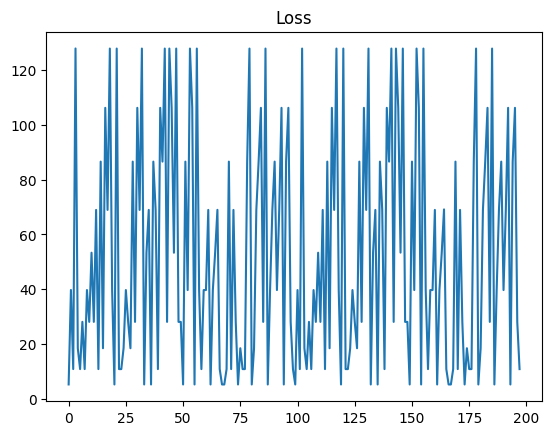

In [13]:
plt.plot(mlp.training_step_outputs)
plt.title('Loss')

Text(0.5, 1.0, 'Loss')

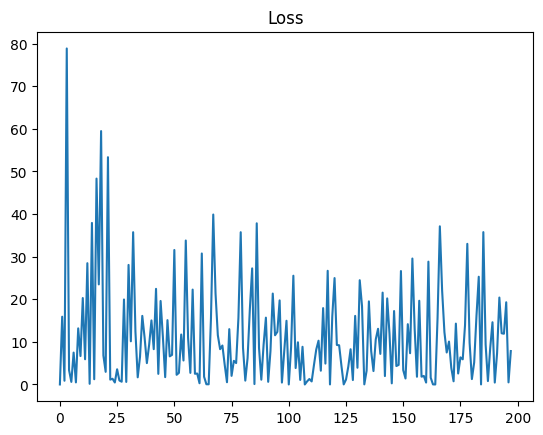

In [14]:
plt.plot(cnn.training_step_outputs)
plt.title('Loss')

Text(0.5, 1.0, 'Loss')

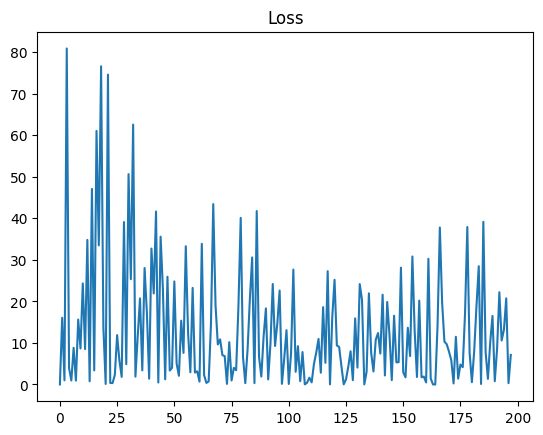

In [15]:
plt.plot(cnn2.training_step_outputs)
plt.title('Loss')

In [16]:
X_batch = torch_X_test[:,:].view(-1,1,28,28).float()
y_batch = torch_y_test[:,0]

with torch.no_grad():
  y_pred_mlp = mlp(X_batch)
  y_pred_cnn = cnn(X_batch)
  y_pred_cnn2 = cnn2(X_batch)

y_pred_mlp__label=y_pred_mlp.argmax(dim=1)
y_pred_cnn__label=y_pred_cnn.argmax(dim=1)
y_pred_cnn2__label=y_pred_cnn2.argmax(dim=1)

#print('True labels:',y_batch)
#print('Predicted labels (mlp):',y_pred_mlp__label)
#print('Predicted labels (cnn):',y_pred_cnn__label)
#print('Predicted labels (cnn2):',y_pred_cnn2__label)

print("Success rate (mlp):",torch.mean(1.*(y_pred_mlp__label==y_batch)))
print("Success rate (cnn):",torch.mean(1.*(y_pred_cnn__label==y_batch)))
print("Success rate (cnn2):",torch.mean(1.*(y_pred_cnn2__label==y_batch)))

Success rate (mlp): tensor(0.0918)
Success rate (cnn): tensor(0.0816)
Success rate (cnn2): tensor(0.1122)


#TO DO: De meilleurs résultats sont encore obtenus avec CNN2

